## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2025">The Repo</a>.  

Once you have updated your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://github.com/apps/databricks">Databricks App on Github</a> or by cloning the repo to your laptop and then uploading the final_project directory and its contents to your workspace using file imports.  Your choice.

<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches to triggering your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)
- [In class examples - Spark Structured Streaming Performance](https://dbc-f85bdc5b-07db.cloud.databricks.com/editor/notebooks/2638424645880316?o=1093580174577663)

### Be sure your project runs end to end when *Run all* is executued on this notebook! (7 points)

### This project is worth 25% of your final grade.
- DSCC-202 Students have 55 possible points on this project (see points above and the instructions below)
- DSCC-402 Students have 60 possible points on this project (one extra section to complete)

In [0]:
%run ./includes/includes

DEPRECATION: Using the pkg_resources metadata backend is deprecated. pip 26.3 will enforce this behaviour change. A possible replacement is to use the default importlib.metadata backend, by unsetting the _PIP_USE_IMPORTLIB_METADATA environment variable. Discussion can be found at https://github.com/pypa/pip/issues/13317
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


Variable Name,Value,Description
TWEET_SOURCE_PATH,dbfs:/FileStore/tables/raw_tweets/,Path where the tweets are coming into your system.
USER_DIR,/tmp/rbondili/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/rbondili/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/rbondili/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/rbondili/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/rbondili/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/rbondili/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/rbondili/gold.delta,Store your Gold Delta Table here.
MODEL_NAME,HF_TWEET_SENTIMENT,Load this production model
HF_MODEL_NAME,finiteautomata/bertweet-base-sentiment-analysis,The Hugging Face Model for Tweet sentiment classification: https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    # Optimize the tables
    optimize_table(BRONZE_DELTA)
    optimize_table(SILVER_DELTA)
    optimize_table(GOLD_DELTA)
    print("Optimized all of the Delta Tables")

## 1.0 Import your libraries here (2 points)
- Are your shuffle partitions consistent with your cluster and your workload?

- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
#library imports
import os
import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, explode, from_json
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType

from delta import DeltaTable

import mlflow
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

#creating spark session
spark = (
    SparkSession.builder
    .appName("TweetSentimentStreaming")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .getOrCreate()
)

spark.conf.set("spark.sql.shuffle.partitions", "80")

/local_disk0/.ephemeral_nfs/envs/pythonEnv-a86eb4b5-181c-4510-baca-04a2fa0b0fb4/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-a86eb4b5-181c-4510-baca-04a2fa0b0fb4/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2025-05-09 16:59:38.605994: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 16:59:38.610943: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 16:59:38.676754: I tensorflow/core/platform/cpu_feature_guard.cc:210] Thi

## 2.0 Define and execute utility functions (3 points)
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# Read the src file
files = dbutils.fs.ls(TWEET_SOURCE_PATH)

# count the files
file_count = len(files)
print(f" Total files: {file_count}")

# printing content of first file
if file_count > 0:
    first_file_path = files[0].path
    
    # Read one file using Spark (as JSON)
    first_file_df = spark.read.json(first_file_path)
    print("\n Contents of 1st tweet file:")
    #first_file_df.show()
    display(first_file_df.toPandas())

else:
    print(" No files found in source directory.")

 Total files: 100000

 Contents of 1st tweet file:


date,sentiment,text,user
Mon Apr 06 22:19:49 PDT 2009,negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!,scotthamilton


## 3.0 Transform the Raw Data to Bronze Data using a stream  (8 points)
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using delta lake to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defined in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql.functions import to_timestamp, regexp_replace, col

# define the schema 
raw_schema = StructType([
    StructField("date", StringType()),
    StructField("sentiment", StringType()),
    StructField("text", StringType()),
    StructField("user", StringType()),
])

# setting up the read stream using Autoloader
bronze_stream = (
    spark.readStream
         .format("cloudFiles")
         .option("cloudFiles.format", "json")
         .option("cloudFiles.schemaLocation", BRONZE_CHECKPOINT)
         .schema(raw_schema)                           
         .load(TWEET_SOURCE_PATH)

         # cleaning date
         .withColumn("clean_date",
                     regexp_replace(regexp_replace(col("date"), r"^\w{3}\s+", ""),  # remove Day of Week
                     r"\s+[A-Z]{3}\s+", " "   # remove Time Zone
             )
         )
         .withColumn( "event_time",to_timestamp(col("clean_date"), "MMM dd HH:mm:ss yyyy"))
         .drop("clean_date")
)

# write the stream to the Bronze Delta table
bronze_stream = (
    bronze_stream.writeStream
                 .format("delta")
                 .option("checkpointLocation", BRONZE_CHECKPOINT)
                 .option("mergeSchema", "true")
                 .outputMode("append")
                 .start(BRONZE_DELTA)
)




## 4.0 Transform the Bronze Data to Silver Data using a stream (5 points)
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

# loading model 
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# udf performs sentiment classification on each tweet
sentiment_udf = udf(lambda txt: sentiment_pipeline(txt)[0]['label'], StringType())

# read from the Bronze Delta table as a stream
silver_stream = (
    spark.readStream
         .format("delta")
         .load(BRONZE_DELTA)
         .withColumn("predicted_sentiment", sentiment_udf(col("text")))
)

# write the stream to the Silver Delta table
(
    silver_stream.writeStream
                 .format("delta")
                 .option("checkpointLocation", SILVER_CHECKPOINT)
                 .option("mergeSchema", "true")
                 .outputMode("append")
                 .start(SILVER_DELTA)
)


/databricks/python/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 5.0 Transform the Silver Data to Gold Data using a stream (7 points)
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
import mlflow
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

# loading defined production model
sentiment_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{MODEL_NAME}/Production", result_type=StringType())

# read from silver delta table and write as gold stream
gold_stream = (
    spark.readStream
         .format("delta")
         .load(SILVER_DELTA)
         .withColumn("predicted_sentiment", sentiment_udf(col("text")))

         .writeStream
            .format("delta")
            .option("checkpointLocation", GOLD_CHECKPOINT)
            .option("mergeSchema", "true")
            .outputMode("append")
            .start(GOLD_DELTA)
)


2025/05/09 17:02:25 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.22.0, required: mlflow==2.21.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/05/09 17:02:25 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2025/05/09 17:02:26 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


## 6.0 Monitor your Streams (5 points)
- Setup a loop that runs at least every 10 seconds
- Print a timestamp of the monitoring query along with the list of streams, rows processed on each, and the processing time on each
- Run the loop until all of the data is processed (0 rows read on each active stream)
- Plot a line graph that shows the data processed by each stream over time
- Plot a line graph that shows the average processing time on each stream over time

2025-05-09 17:03:04.581912 | Stream 94fd85c0-3424-481a-8165-c3cbefc23001: rows=0, duration=0 ms
2025-05-09 17:03:04.581912 | Stream fafb79be-97fc-4035-9255-498acaa8512f: rows=1000, duration=70100 ms
2025-05-09 17:03:04.581912 | Stream 1dc27500-5f94-42c2-b901-6541187ccc37: rows=0, duration=0 ms
2025-05-09 17:03:14.598798 | Stream 94fd85c0-3424-481a-8165-c3cbefc23001: rows=0, duration=0 ms
2025-05-09 17:03:14.598798 | Stream fafb79be-97fc-4035-9255-498acaa8512f: rows=1000, duration=70100 ms
2025-05-09 17:03:14.598798 | Stream 1dc27500-5f94-42c2-b901-6541187ccc37: rows=0, duration=0 ms
2025-05-09 17:03:24.613642 | Stream 94fd85c0-3424-481a-8165-c3cbefc23001: rows=0, duration=0 ms
2025-05-09 17:03:24.613642 | Stream fafb79be-97fc-4035-9255-498acaa8512f: rows=1000, duration=70100 ms
2025-05-09 17:03:24.613642 | Stream 1dc27500-5f94-42c2-b901-6541187ccc37: rows=0, duration=0 ms
2025-05-09 17:03:34.630026 | Stream 94fd85c0-3424-481a-8165-c3cbefc23001: rows=0, duration=0 ms
2025-05-09 17:03:34

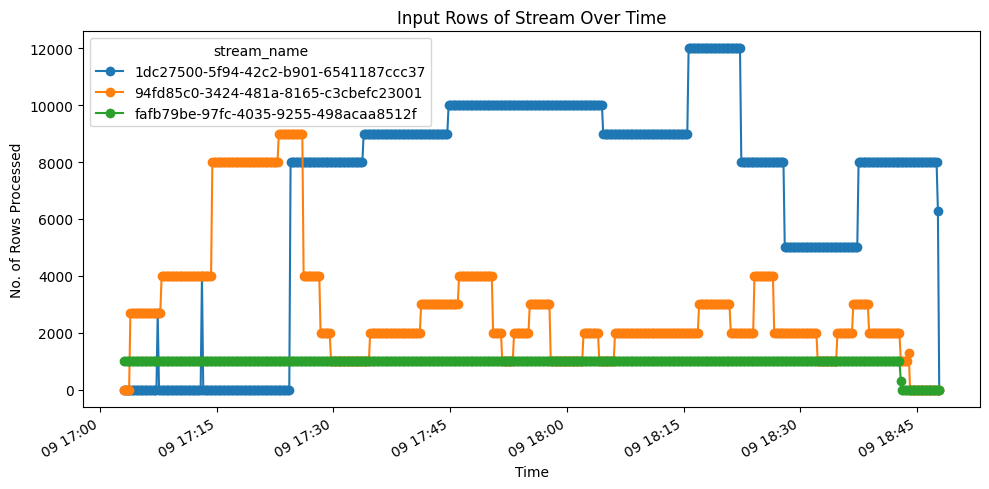

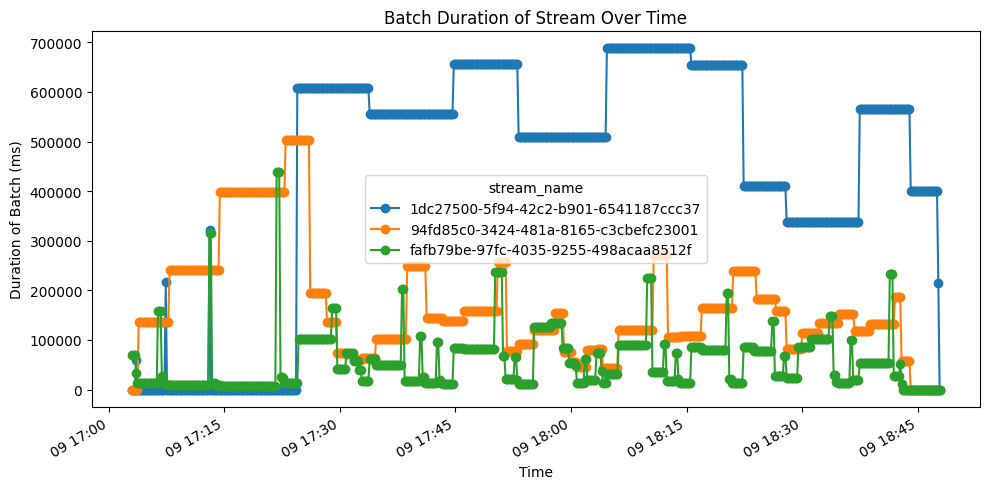

In [0]:
import time
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

metrics = []

# run untill all rows are processed
while True:
    timestamp = datetime.now()
    active_queries = spark.streams.active
    
    if not active_queries:
        print(f"{timestamp} : There are no active streams.")
        break

    all_zero = True
    for q in active_queries:
        prog = q.recentProgress[-1] if q.recentProgress else {}
        rows = prog.get("numInputRows", 0)
        duration= prog.get("batchDuration", 0)
        
        metrics.append({
            "timestamp": timestamp,
            "stream_id":   q.id,
            "stream_name": q.name or q.id,
            "numInputRows": rows,
            "batchDuration": duration
        })
        
        print(f"{timestamp} | Stream {q.name or q.id}: rows={rows}, duration={duration} ms")
        if rows > 0:
            all_zero = False

    if all_zero:
        print(f"{timestamp} : All streams have been processed!")
        break

    time.sleep(10) #loop runs every 10 sec 

# plotting
df_metrics = pd.DataFrame(metrics)
if df_metrics.empty:
    print("No data hence there will be no plots.")
else:
    df_metrics["timestamp"] = pd.to_datetime(df_metrics["timestamp"])
    df_metrics.set_index("timestamp", inplace=True)

    ax = df_metrics.pivot(columns="stream_name", values="numInputRows").plot(
        figsize=(10,5), marker="o"
    )
    ax.set_xlabel("Time")
    ax.set_ylabel("No. of Rows Processed")
    ax.set_title("Input Rows of Stream Over Time")
    plt.tight_layout()
    plt.show()

    # Plot batch duration over time
    ax2 = df_metrics.pivot(columns="stream_name", values="batchDuration").plot(
        figsize=(10,5), marker="o"
    )
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Duration of Batch (ms)")
    ax2.set_title("Batch Duration of Stream Over Time")
    plt.tight_layout()
    plt.show()


## 7.0 Bronze Data Exploratory Data Analysis (5 points)
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


Total tweets in Bronze Table: 100000

Nan/Null values per column:


null_values
0
0
0
0
0



 Number of tweet counts per user:
+--------------+-----+
|user          |count|
+--------------+-----+
|tweetpet      |132  |
|iHomeTech     |69   |
|nuttychris    |58   |
|Hollywood_Trey|56   |
|sebby_peek    |39   |
|SarahSaner    |36   |
|Dogbook       |35   |
|tsarnick      |35   |
|whitsundays   |32   |
|MyAppleStuff  |31   |
+--------------+-----+
only showing top 10 rows


No. of tweets with at least one mention: 46849
No. of tweets with no mentions: 53151


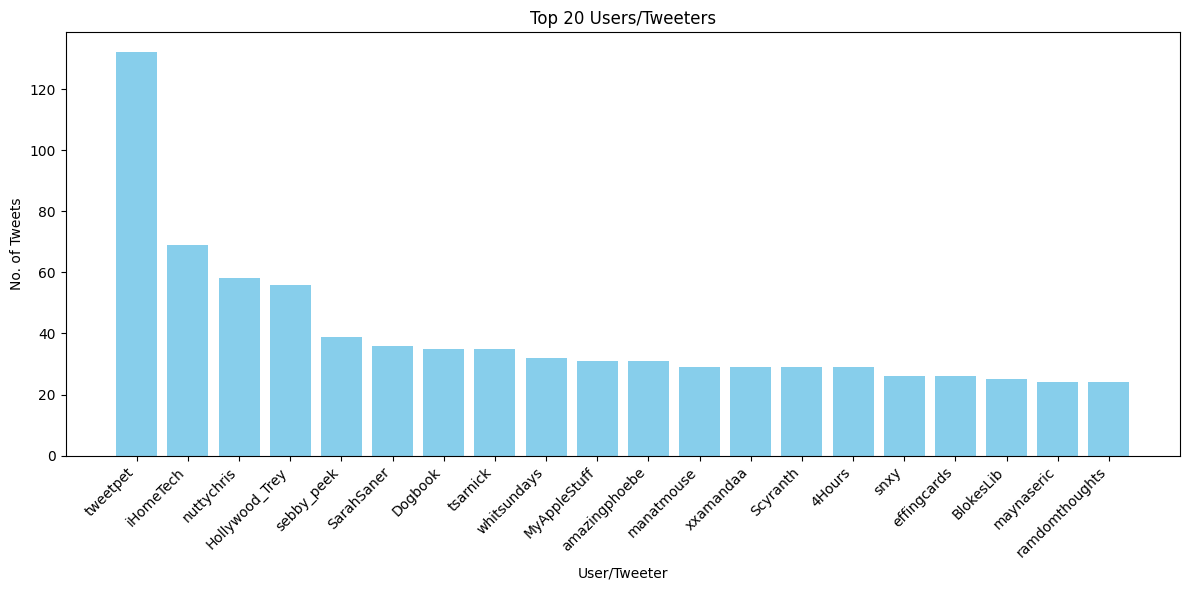

In [0]:
from pyspark.sql.functions import col, sum as spark_sum, when
import matplotlib.pyplot as plt

bronze_df = spark.read.format("delta").load(BRONZE_DELTA)

tot_tweets = bronze_df.count()
print(f"Total tweets in Bronze Table: {tot_tweets}")

null_values = (
    bronze_df
    .select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in bronze_df.columns])
    .toPandas()
    .T
    .rename(columns={0: "null_values"})
)
print("\nNan/Null values per column:")
display(null_values)

user_counts = (
    bronze_df
    .groupBy("user")
    .count()
    .orderBy(col("count").desc())
)
print("\n Number of tweet counts per user:")

user_counts.show(10, truncate=False)

w_mentions    = bronze_df.filter(col("text").rlike(r"@\w+")).count()
wout_mentions = tot_tweets - w_mentions
print(f"\nNo. of tweets with at least one mention: {w_mentions}")
print(f"No. of tweets with no mentions: {wout_mentions}")

topusers = user_counts.limit(20).toPandas()

plt.figure(figsize=(12, 6))
plt.bar(topusers['user'], topusers['count'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("User/Tweeter")
plt.ylabel("No. of Tweets")
plt.title("Top 20 Users/Tweeters")
plt.tight_layout()
plt.show()


## 8.0 Capture the accuracy metrics from the gold table in MLflow  (4 points)
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the model name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

Accuracy Metrics: precision=0.83, recall=0.82, f1 score=0.83


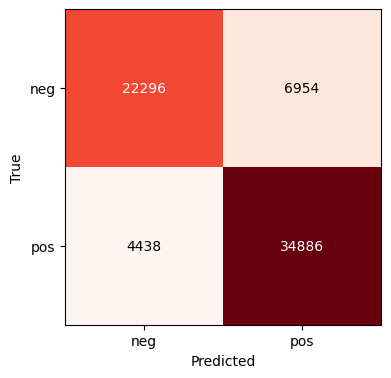

In [0]:
from pyspark.sql.functions import col, create_map, lit
from itertools import chain
from delta.tables import DeltaTable
import mlflow
import sklearn.metrics as skm
import matplotlib.pyplot as plt

gold_df = spark.read.format("delta").load(GOLD_DELTA)

label_dict = {
    "LABEL_0": "negative", "LABEL_1": "neutral",  "LABEL_2": "positive",
    "NEG":     "negative", "NEU":       "neutral", "POS":      "positive"
}
map_expr = create_map( *list(chain.from_iterable([(lit(k), lit(v)) for k, v in label_dict.items()])) )

gold_labels = gold_df.withColumn("pred_label", map_expr[col("predicted_sentiment")])

# keep neg/pos labels 
binary_df = gold_labels.filter( (col("sentiment").isin("negative","positive")) & (col("pred_label").isin("negative","positive")))
pdf = binary_df.select("sentiment","pred_label").toPandas()
y_true, y_pred = pdf["sentiment"], pdf["pred_label"]

# calculate precision, recall, F1
precision, recall, f1, _ = skm.precision_recall_fscore_support(
    y_true, y_pred,
    labels=["negative","positive"],
    average="macro",
    zero_division=0 )

# plot confusion matrix 
matrix = skm.confusion_matrix(y_true, y_pred, labels=["negative","positive"])
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(matrix, cmap="Reds")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["neg","pos"]); ax.set_yticklabels(["neg","pos"])
for i in (0,1):
    for j in (0,1):
        ax.text(j, i, matrix[i,j], ha="center", va="center",
                color="white" if matrix[i,j] > matrix.max()/2 else "black")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png")

gold_version = DeltaTable.forPath(spark, GOLD_DELTA).history(1).collect()[0]["version"]
with mlflow.start_run(run_name="gold_accuracy_metrics"):
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1",  f1)
    mlflow.log_param("model_name", MODEL_NAME)
    mlflow.log_param("mlflow_version", mlflow.__version__)
    mlflow.log_param("input_gold_version", gold_version)
    mlflow.log_artifact("confusion_matrix.png")

print(f"Accuracy Metrics: precision={precision:.2f}, recall={recall:.2f}, f1 score={f1:.2f}")


## 9.0 Application Data Processing and Visualization (6 points)
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

total mentions: 49239
Top 20 Positive Sentiment Mentions:


mentions,positive,neutral,negative,total
mileycyrus,233,78,29,340
ddlovato,199,49,26,274
tommcfly,193,55,23,271
JonathanRKnight,91,34,10,135
nick_carter,77,32,16,125
selenagomez,71,11,2,84
MariahCarey,61,14,8,83
aplusk,56,29,19,104
dougiemcfly,55,26,11,92
DonnieWahlberg,55,12,14,81


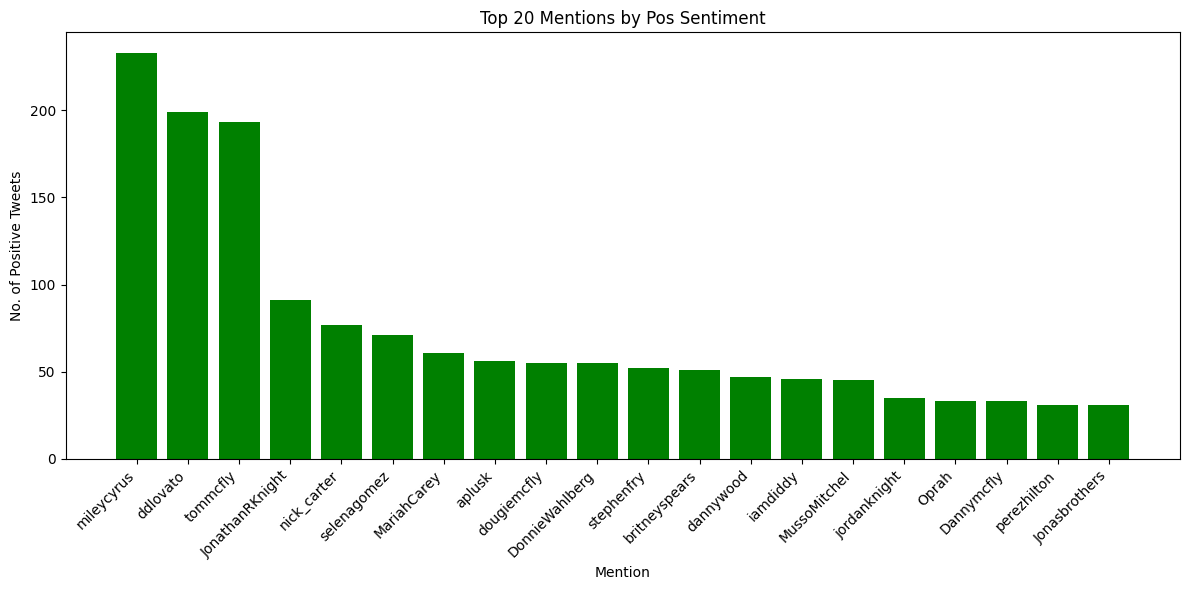

Top 20 Negative Sentiment Mentions:


mentions,positive,neutral,negative,total
mileycyrus,233,78,29,340
ddlovato,199,49,26,274
JoelMadden,22,8,24,54
tommcfly,193,55,23,271
aplusk,56,29,19,104
stephenfry,52,26,17,95
nick_carter,77,32,16,125
petewentz,20,20,16,56
perezhilton,31,16,15,62
Schofe,27,18,15,60


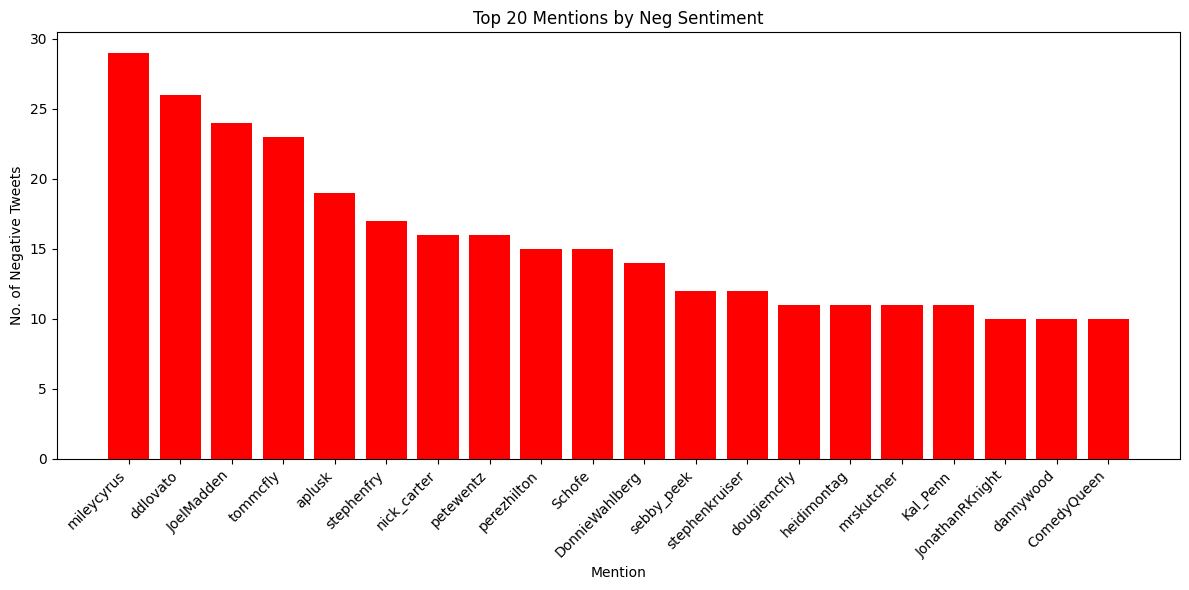

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

gold_df = spark.read.format("delta").load(GOLD_DELTA)

labels = { "LABEL_0": "negative", "LABEL_1": "neutral",  "LABEL_2": "positive", "NEG": "negative", "NEU": "neutral", "POS": "positive" }
map_expr = create_map( *list(chain.from_iterable([(lit(k), lit(v)) for k, v in labels.items()])) )
gold_norm = gold_df.withColumn("pred_label", map_expr[col("predicted_sentiment")])

pdf = gold_norm.select("text", "pred_label").toPandas()
pdf["mentions"] = pdf["text"].str.findall(r"@(\w+)")

exploded = pdf.explode("mentions").dropna(subset=["mentions"])

mention_count = (
    exploded
      .groupby(["mentions", "pred_label"])
      .size()
      .unstack(fill_value=0)
)
for sentiment in ["negative", "neutral", "positive"]:
    if sentiment not in mention_count.columns:
        mention_counts[sentiment] = 0

# Sort the mention count totals in descending order
mention_count["total"] = mention_count[["negative", "neutral", "positive"]].sum(axis=1)
count_sorted = mention_count.sort_values("total", ascending=False)

# Capture the total for each mention in a new column
tot_mentions = int(mention_count["total"].sum())
print(f"total mentions: {tot_mentions}")

# top 20 POS sentiment
top_pos = count_sorted.nlargest(20, "positive").reset_index()
print("Top 20 Positive Sentiment Mentions:")
display(top_pos[["mentions", "positive", "neutral", "negative", "total"]])

plt.figure(figsize=(12, 6))
plt.bar(top_pos["mentions"], top_pos["positive"], color="green")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Mention")
plt.ylabel("No. of Positive Tweets")
plt.title("Top 20 Mentions by Pos Sentiment")
plt.tight_layout()
plt.show()

# Top 20 by negative sentiment
top_neg = count_sorted.nlargest(20, "negative").reset_index()
print("Top 20 Negative Sentiment Mentions:")
display(top_neg[["mentions", "positive", "neutral", "negative", "total"]])

plt.figure(figsize=(12, 6))
plt.bar(top_neg["mentions"], top_neg["negative"], color="red")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Mention")
plt.ylabel("No. of Negative Tweets")
plt.title("Top 20 Mentions by Neg Sentiment")
plt.tight_layout()
plt.show()


## 10.0 Clean up and completion of your pipeline (3 points)
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook. Note: In the includes there is a variable START_TIME that captures the starting time of the notebook.

In [0]:
import time
from delta.tables import DeltaTable

# list any active streams
active_queries = spark.streams.active
if not active_queries:
     print("No active streams.")
else:
     print("Currently running active streams:")
     for q in active_queries:
         print(f"  • id = {q.id}, status = {q.status['message']}")

# stop streams
for q in active_queries:
     q.stop()
print("All streaming queries have been stopped.\n")

# print elapsed time
elapsed_time = time.time() - START_TIME
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Currently running active streams:
  • id = 94fd85c0-3424-481a-8165-c3cbefc23001, status = Waiting for data to arrive
  • id = fafb79be-97fc-4035-9255-498acaa8512f, status = Waiting for data to arrive
  • id = 1dc27500-5f94-42c2-b901-6541187ccc37, status = Waiting for data to arrive
All streaming queries have been stopped.

Elapsed time: 7067.38 seconds


## 11.0 How Optimized is your Spark Application (Grad Students Only) (5 points)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

- **Spill**: There was no evidence of spill meaning we've allocated enough executor memory for the current workload. The consistency in partition sizes throughout various jobs and the small file sizes at the source support these findings. 

- **Skew**: There is evidence of skew. One task handled just 8 records in 2 s, while another processed 928 records in 4.6 min. This happens because Spark launches one task per Parquet file, and our micro-batches produce files of wildly different sizes. The larger partitions incur far more Python-UDF work, stretching their runtimes. To level the workload, we can repartition the DataFrame into evenly sized shards (e.g. df.repartition(n)) and/or tune the Autoloader’s maxFilesPerTrigger so each micro-batch outputs files of similar size. [Skew Screenshot](https://drive.google.com/file/d/1hzEy3rw0TgT8OVHhStakPt9ViG9yEzFO/view?usp=sharing)

- **Shuffle**:  In Stage 186 we see a non-zero shuffle: Shuffle Read Size / Records = 93 KiB / 416, Shuffle Write Size / Records = 489 B / 1. This confirms a wide transformation (e.g. a join or groupBy) moved data across executors, incurring network I/O and serialization overhead. Even this modest 93 KiB fetch added latency which at larger scale could increase to MB/GB. To reduce shuffle costs, we can broadcast small DataFrames (e.g. via broadcast(df)), pre-repartition on join keys (df.repartition(numPartitions, "key")), or combine operations to minimize the number of shuffle boundaries. [Shuffle Screenshot](https://drive.google.com/file/d/11U4ZhGLCu-aB-fX17OliecT_iVXEv5Dz/view?usp=drive_link)

- **Storage**: Because we never called .cache(), the Storage tab shows no RDD blocks or in-memory usage, but the Stages view still exposes storage inefficiency via the file-scan metrics. For example, in one stage, Spark launched one task per Parquet file (9 tasks) yet each task read only a few KiB (e.g. Input Size / Records = 2.4 KiB / 8 in the min case), revealing increase of tiny files. That small-file overhead drives up task-launch and I/O costs. To fix this, we should compact our Delta tables with OPTIMIZE (to merge files into larger Parquets) and run VACUUM (to clean up old file versions), thereby streamlining downstream scans. [Storage Screenshot](https://drive.google.com/file/d/1hzEy3rw0TgT8OVHhStakPt9ViG9yEzFO/view?usp=sharing)

- **Serialization**: In our run, the summary shows Task Deserialization at a median of ~25 ms (max ~37 ms) and Result Serialization at 0 ms across all tasks—meaning Java serialization overhead is effectively negligible compared to Python-UDF work. If these numbers were high, we would reduce them by minimizing large object transfers between tasks.
[Serialization Screenshot](https://drive.google.com/file/d/1bTdfyhhM-d00lNuGtHC4Q6_1nXChU2Ct/view?usp=drive_link)
